In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
import scipy
import os
import scipy.ndimage
from skimage.transform import SimilarityTransform, warp
import datetime
import random as rd
from pylab import *
from scipy import signal
from scipy import *
from PIL import Image

In [18]:
img = cv2.imread('sudoku1.jpg').astype(np.uint8)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
im = Image.fromarray(gray, mode='L')
im.show()

In [19]:
# blur = cv2.GaussianBlur(gray,(3,3),0)
# im = Image.fromarray(blur, mode='L')
# im.show()

In [20]:
edges = cv2.Canny(gray,50,100)
im = Image.fromarray(edges, mode='L')
im.show()

In [22]:
_, contours, _ = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea,reverse=True)[:1]
contoured = np.copy(img)
cv2.drawContours(contoured, contours, -1, (0,255,0), 3)
im = Image.fromarray(contoured, mode='RGB')
im.show()

In [25]:
# plot contour on black background
empty = np.zeros(img.shape).astype(np.uint8)
tmp = cv2.drawContours(empty, contours, -1, (0,255,0), 3)
print(tmp.shape)
for p in contours[0]:
    x,y=p[0][1], p[0][0]
    tmp[x-2:x+3, y-2:y+3, 0] = np.ones((5,5)).astype(np.uint8)*255
    tmp[x-2:x+3, y-2:y+3, 1] = np.zeros((5,5)).astype(np.uint8)

x,y=contours[0][0][0][1], contours[0][0][0][0]
tmp[x-3:x+4, y-3:y+4, 2] = np.ones((7,7)).astype(np.uint8)*255
tmp[x-3:x+4, y-3:y+4, 1] = np.zeros((7,7)).astype(np.uint8)
tmp[x-3:x+4, y-3:y+4, 0] = np.zeros((7,7)).astype(np.uint8)
tmp = Image.fromarray(tmp, mode='RGB')
tmp.show()

(423, 419, 3)


In [27]:
# get four corner
for i in range(1,1000):
    epsilon = i*0.001*cv2.arcLength(contours[0],True)
    approx = cv2.approxPolyDP(contours[0],epsilon,True)
    if len(approx)<=4:
        approx = np.array([n[0] for n in approx]).astype(np.float32)
        break

x_idx = np.argsort(approx[:,0])
first_2_x = approx[x_idx[:2],:]
y_idx = np.argsort(first_2_x[:,1])
[p00, p01] = x_idx[y_idx]
last_2_x = approx[x_idx[2:],:]
y_idx = np.argsort(last_2_x[:,1])+2
[p10, p11] = x_idx[y_idx]

approx = approx[[p00,p10,p11,p01],:]
print("Four corners of the contour:",approx)

Four corners of the contour: [[ 54.  63.]
 [369.  51.]
 [390. 392.]
 [ 26. 388.]]


In [28]:
# transform image
h = np.array([ [0,0],[449,0],[449,449],[0,449]]).astype(np.float32)
transform = cv2.getPerspectiveTransform(approx,h)
warp = cv2.warpPerspective(img,transform,(450,450))
im = Image.fromarray(warp, mode='RGB')
im.show()

In [29]:
# cut image
cells=[]
for i in range(9):
    for j in range(9):
        cells.append(warp[i*50:(i+1)*50,j*50:(j+1)*50])


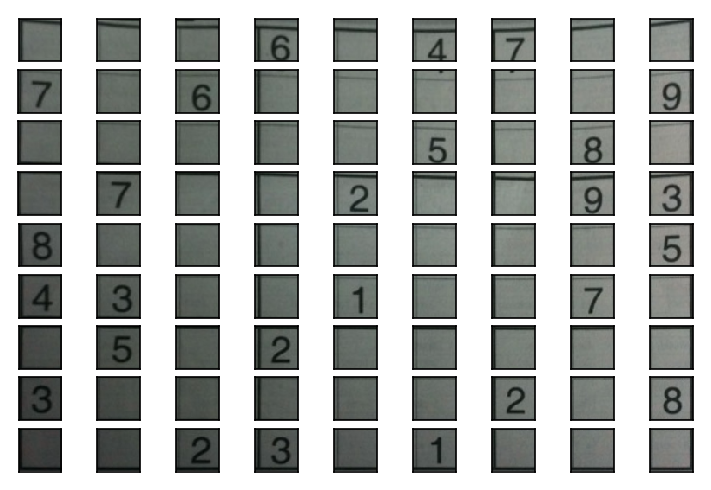

In [30]:
fig = plt.figure(dpi=150)
for i in range(9):
    for j in range(9):
        a = fig.add_subplot(9, 9, i*9+j+1)
        a.axes.get_xaxis().set_ticks([])
        a.axes.get_yaxis().set_ticks([])
        plt.imshow(cells[i*9+j])
plt.show()